# Градиентный бустинг

In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from xgboost import XGBRegressor
%pylab inline

RANDOM_SEED = 0

Populating the interactive namespace from numpy and matplotlib


!pip install xgboost==1.0.2
!pip install scikit-learn==0.22.1
!pip install hyperopt==0.2.3

In [69]:
import xgboost
import sklearn
import hyperopt
print('Sklearn: {},\nXGBoost: {},\nhyperopt: {}'.format(sklearn.__version__, 
                                                        xgboost.__version__, 
                                                        hyperopt.__version__))

Sklearn: 0.22.1,
XGBoost: 0.90,
hyperopt: 0.2.3


## Данные для эксперимента

In [70]:
# Загрузим датасет california_housing
clf_dataset = fetch_california_housing()

In [71]:
data = clf_dataset.data
target = clf_dataset.target
data.shape, target.shape

((20640, 8), (20640,))

In [72]:
# Сделаем случайную выборку из 2000 объектов
n_samples = 2000
np.random.seed(RANDOM_SEED)
samples = np.random.choice(np.arange(data.shape[0]), n_samples, replace=False)
data = data[samples]
target = target[samples]
data.shape, target.shape

((2000, 8), (2000,))

In [73]:
# Сформируем датафрейм из новой выборки, объединив его с таргетом
full_df = pd.DataFrame(data, columns=['clm_{}'.format(i) for i in range(data.shape[1])])
full_df['target'] = target
full_df.head()

,clm_0,clm_1,clm_2,clm_3,clm_4,clm_5,clm_6,clm_7,target
0,4.1518,22.0,5.663073,1.075472,1551.0,4.180593,32.58,-117.05,1.369
1,5.7796,32.0,6.107226,0.927739,1296.0,3.020979,33.92,-117.97,2.413
2,4.3487,29.0,5.930712,1.026217,1554.0,2.910112,38.65,-121.84,2.007
3,2.4511,37.0,4.992958,1.316901,390.0,2.746479,33.20,-115.60,0.725
4,5.0049,25.0,4.319261,1.039578,649.0,1.712401,37.79,-122.43,4.600


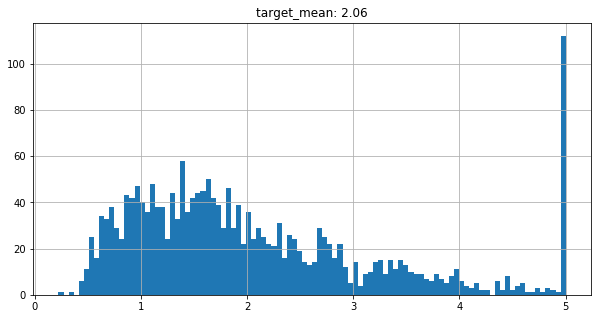

In [74]:
# Посмотрим на таргет
plt.figure(figsize=(10,5))
plt.title('target_mean: {}'.format(round(full_df['target'].mean(), 3)))
full_df['target'].hist(bins=100);

- Таргет вещественный, значит будем решать задачу регрессии.
- Есть выброс в районе 5, на который пока не обращаем внимание.

In [75]:
# Разделим выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(full_df.drop('target', axis=1), 
                                                    full_df['target'], 
                                                    test_size=0.3, 
                                                    random_state=RANDOM_SEED)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1400, 8), (600, 8), (1400,), (600,))

## Константная модель

In [76]:
y_trn_pred = [y_train.mean()]*len(y_train)
y_tst_pred = [y_train.mean()]*len(y_test)
mse_train = mean_squared_error(y_train, y_trn_pred)
mse_test = mean_squared_error(y_test, y_tst_pred)
print('rmse_train: {}, rmse_test: {}'.format(round(np.sqrt(mse_train), 3), round(np.sqrt(mse_test), 3)))

rmse_train: 1.184, rmse_test: 1.161


- Пока полученные цифры нам мало о чем говорят, разве что train и test выборки сбалансированные, так как метрики на train и test близки.
- Но мы можем зафиксировать значение mse_test = 1.16 как бейзлайн, на который будем ориентироваться при построение более сложных моделей.

## Реализация градиентного бустинга

### Определим функцию для расчета вектора сдвигов S
Выберем в качестве функции потерь MSE:

   \\[L=(y-y_{predict})^2\\]
    
Вектор сдвигов представляет собой производную функции потерь, посчитанную на всем объеме выборки:

   \\[s_i =-L'(y_i, y_{predict_i})\\]
         
После вычисления производной получим следующее выражение для определения s. Множитель 2, который получился после дифференцирования квадрата разности, проигнорируем, поскольку в дальнейшем мы будем подбирать множитель базового алгоритма:

   \\[s_i=y_i-y_{predict_i}\\]   
         
    

In [77]:
# Определим функцию для расчета вектора сдвигов S
def S(y_train, y_predict):     
    return list(map(lambda x, y: (x - y), y_train, y_predict))    

### Реализуем алгоритм обучения градиентного бустинга над деревьями
Проинициализируем модель бустинга следующими параметрами:
- Число деревьев: 50
- Коэффициент шага алгоритма: 1.0
- Глубина дерева: 2
- Random_state: 0

    1.Создадим список, где будут храниться наши базовые алгоритмы.
    
    2.Зададимся неким нулевым базовым алгоритмом. Например, константный алгоритм, который на выходе выдает тоже самое, что получает на вход.
    
    3.Обучим в цикле все деревья, научим их приближать вектор сдвигов, расчитанный на основе прогнозов предыдущего композиции алгоритмов.
    
    4.Получим итоговый прогноз как сумму прогнозов базовых алгоритмов с учетом коэффициента шага.

In [78]:
# Функция вычисления прогноза композиции алгоритмов 
def gbm_predict(X, algo_list, coeff_list):
    predict_lst = []
    for algo, coeff in zip(algo_list, coeff_list):
        predict_lst.append(coeff * algo.predict(X))
    return np.array(predict_lst).sum(axis=0)

In [79]:
# Инициализация параметров модели
n_trees = 50
max_depth = 2
eta = 1.0
eta_list = [eta] * n_trees
y0 = y_train
base_algo_list = []

# Обучение модели
for i in tqdm(range(n_trees)):
    estimator = DecisionTreeRegressor(max_depth=max_depth, random_state=RANDOM_SEED)
    base_algo_list.append(estimator.fit(X_train, S(y_train, y0)))
    y0 = gbm_predict(X_train.values, base_algo_list, eta_list)

# Ответ финальной композиции деревьев
y_pred_test = gbm_predict(X_test.values, base_algo_list, eta_list) 
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(np.round(rmse, 4))


0.659


Используя предложенную выше реализацию GBM, проведем эксперимент: инициализируем базовый алгоритм медианой таргета обучающей выборки и переобучим модель, обучим бустинг не меняя параметров инициализации.

In [80]:
# Инициализация параметров модели
n_trees = 50
max_depth = 2
eta = 1.0
eta_list = [eta] * n_trees
y0 = [y_train.median()]*len(y_train)
base_algo_list = []

# Обучение модели
for i in tqdm(range(n_trees)):
    estimator = DecisionTreeRegressor(max_depth=max_depth, random_state=RANDOM_SEED)
    base_algo_list.append(estimator.fit(X_train, S(y_train, y0)))
    y0 = gbm_predict(X_train.values, base_algo_list, eta_list)

# Ответ финальной композиции деревьев
y_pred_test = gbm_predict(X_test.values, base_algo_list, eta_list) 
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(np.round(rmse, 4))


0.6586


Используя предложенную выше реализацию GBM, проведем эксперимент: в качестве базового алгоритма применим линейную модель LinearRegression из sklearn, обучим бустинг не меняя параметров инициализации.

In [81]:
# Инициализация параметров модели
n_trees = 50
max_depth = 2
eta = 1.0
eta_list = [eta] * n_trees
y0 = y_train
base_algo_list = []

# Обучение модели
for i in tqdm(range(n_trees)):
    estimator = LinearRegression()
    base_algo_list.append(estimator.fit(X_train, S(y_train, y0)))
    y0 = gbm_predict(X_train.values, base_algo_list, eta_list)

# Ответ финальной композиции 
y_pred_test = gbm_predict(X_test.values, base_algo_list, eta_list) 
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(np.round(rmse, 3))





0.746


### Оценим влияние коэффициента шага алгоритма (eta) на ошибку модели
Шаг для всех базовых алгоритмов композиции останется постоянным. Будем менять шаг eta только для всей композиции и оценим его влияние на rmse.

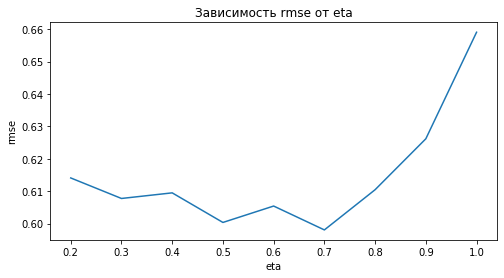

In [82]:
rmse_list = []
for eta in tqdm(np.arange(1.0, 0.1, -0.1)):
    n_trees = 50
    max_depth = 2
    y0 = y_train
    base_algo_list = []
    eta_list = [round(eta, 1)] * n_trees
    # Обучение модели
    for i in range(n_trees):
        estimator = DecisionTreeRegressor(max_depth=max_depth, random_state=RANDOM_SEED)    
        base_algo_list.append(estimator.fit(X_train, S(y_train, y0)))
        y0 = gbm_predict(X_train.values, base_algo_list, eta_list)

    # Ответ финальной композиции деревьев
    y_pred_test = gbm_predict(X_test.values, base_algo_list, eta_list) 
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    rmse_list.append(rmse)
    
plt.figure(figsize=(8,4))
plt.plot(np.arange(1.0, 0.1, -0.1), rmse_list);
plt.title('Зависимость rmse от eta')
plt.xlabel('eta')
plt.ylabel('rmse');

- После значения eta > 0.7 наша модель начинает переобучаться.  

Недостаток постоянства шага для базовых алгоритмов композиции заключается в том, что ошибки вблизи минимума не могут достигнуть экстремума и постоянно перескакивют его. Поэтому желательно, чтобы с каждым шагом, для нового базового алгоритма параметр eta уменьшался.
- Реализуем снижение шага eta для базовых алгоритмов в рамках обучения одной композиции по следующему закону:

    \\[eta_i = \frac{1.0}{1.0+0.1*i}\\]
    
   

In [83]:
n_trees = 50
max_depth = 2
y0 = y_train
base_algo_list = []
# Обучение модели
for i in range(n_trees):
    eta_list = [1 / (1 + 0.1 * i)]*n_trees
    estimator = DecisionTreeRegressor(max_depth=max_depth, 
                                      random_state=RANDOM_SEED)    
    base_algo_list.append(estimator.fit(X_train, S(y_train, y0)))
    y0 = gbm_predict(X_train.values, base_algo_list, eta_list)

# Ответ финальной композиции 
y_pred_test = gbm_predict(X_test.values, base_algo_list, eta_list) 
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(np.round(rmse, 3))





0.697


## Работа с раличными реализациями градиентного бустинга
### Оценим влияние различных параметров градиентного бустинга на ошибку модели на примере реализации из sklearn - ***GradientBoostingRegressor***

In [84]:
print('------------------') 
print('Go for estimators..')
n_estim_list = np.arange(2,200,10)
rmse_estim = []
for estimator in tqdm(n_estim_list):
    regressor = GradientBoostingRegressor(n_estimators = estimator,
                                          max_depth = 20,
                                         random_state=RANDOM_SEED)
    regressor.fit(X_train, y_train)
    rmse_estim.append(np.sqrt(mean_squared_error(y_test, regressor.predict(X_test)))) 

print('------------------')   
print('Go for max_depth..')
max_depth_list = np.arange(1,100,10)
rmse_depth = []
for depth in tqdm(max_depth_list):
    regressor = GradientBoostingRegressor(n_estimators = 50,
                                          max_depth = depth,
                                         random_state=RANDOM_SEED)
    regressor.fit(X_train, y_train)
    rmse_depth.append(np.sqrt(mean_squared_error(y_test, regressor.predict(X_test))))

------------------
Go for estimators..



------------------
Go for max_depth..


Text(0.5, 1.0, 'RMSE for depth')

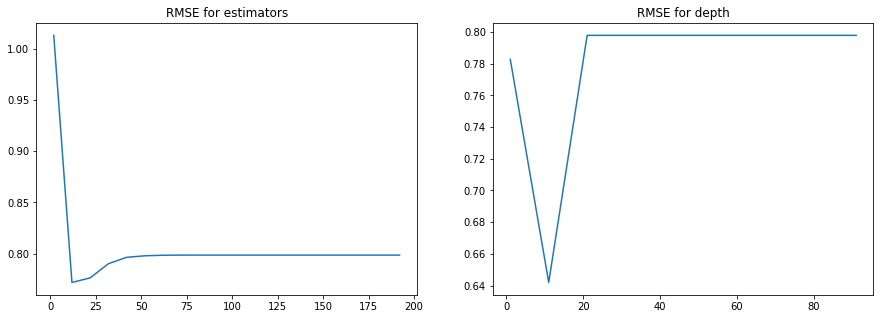

In [85]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(n_estim_list, rmse_estim)
pyplot.title('RMSE for estimators')
    
plt.subplot(1,2,2)
pyplot.plot(max_depth_list, rmse_depth)
pyplot.title('RMSE for depth')

- С увеличением числа деревьев, начиная с некоторого момента, градиентный бустинг начинает переобучаться.
- С ростом глубины деревьев, начиная с некоторого момента, качество работы градиентного бустинга на тестовой выборке также начинает ухудшаться, то есть модель переобучается.


Оценим влияние параметра ***learning_rate*** (аналог eta) рассмотренной выше модели ***GradientBoostingRegressor*** на RMSE.
- Построим изменение RMSE в зависимости от ***learning_rate*** в диапазоне от 0.1 до 1.0 (включительно) с шагом 0.1 для train и test выборок.
- Оценим значение ***learning_rate*** при котором начинается переобучение. 

Text(0.5, 1.0, 'RMSE for learning rate')

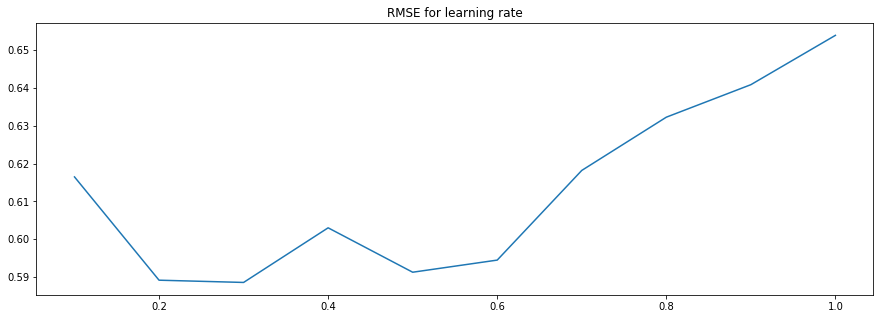

In [86]:
learning_rate_list = np.arange(0.1, 1.1, 0.1)
rmse_lr = []
rmse_lr_train = []
for learn_rate in tqdm(learning_rate_list):
    regressor = GradientBoostingRegressor(n_estimators=100,
                                          max_depth=2,
                                          random_state=RANDOM_SEED,
                                          learning_rate=learn_rate)
    regressor.fit(X_train, y_train)
    rmse_lr.append(np.sqrt(mean_squared_error(y_test, regressor.predict(X_test))))
    rmse_lr_train.append(np.sqrt(mean_squared_error(y_train, regressor.predict(X_train))))

plt.figure(figsize=(15,5))
plt.plot(learning_rate_list, rmse_lr)
#plt.plot(learning_rate_list, rmse_lr_train)
pyplot.title('RMSE for learning rate')




При learning rate, равном 0.3, начинается переобучение.

## XGBoost
### Рассмотрим некоторые удобные функции библиотеки XGBoost:
- Останов по значению метрики на валидации.
- Визуализация.
- Важность признаков


In [114]:
# Обучим модель XGBRegressor c заданным параметром early_stopping_rounds
xgb = XGBRegressor(n_estimators=1000, random_state=RANDOM_SEED)
xgb.fit(X_train, y_train,
        eval_set=[(X_train, y_train),(X_test, y_test)],
        eval_metric='rmse',
        verbose=True,
        early_stopping_rounds=10
        )
np.sqrt(mean_squared_error(y_test, xgb.predict(X_test)))

[20:28:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.80319	validation_1-rmse:1.77049
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.65747	validation_1-rmse:1.63116
[2]	validation_0-rmse:1.5298	validation_1-rmse:1.51029
[3]	validation_0-rmse:1.41583	validation_1-rmse:1.40453
[4]	validation_0-rmse:1.31527	validation_1-rmse:1.30982
[5]	validation_0-rmse:1.22703	validation_1-rmse:1.22537
[6]	validation_0-rmse:1.14886	validation_1-rmse:1.15623
[7]	validation_0-rmse:1.08034	validation_1-rmse:1.09165
[8]	validation_0-rmse:1.02077	validation_1-rmse:1.03691
[9]	validation_0-rmse:0.968407	validation_1-rmse:0.991251
[10]	validation_0-rmse:0.922187	validation_1-rmse:0.949035
[11]	validation_0-rmse:0.881363	validation_1-rmse:0.913705
[12]	validation_0-rmse:0.844618	validation_1-r

[135]	validation_0-rmse:0.380651	validation_1-rmse:0.581825
[136]	validation_0-rmse:0.379608	validation_1-rmse:0.581348
[137]	validation_0-rmse:0.378719	validation_1-rmse:0.581187
[138]	validation_0-rmse:0.376784	validation_1-rmse:0.580553
[139]	validation_0-rmse:0.375546	validation_1-rmse:0.580822
[140]	validation_0-rmse:0.374886	validation_1-rmse:0.580291
[141]	validation_0-rmse:0.374125	validation_1-rmse:0.579764
[142]	validation_0-rmse:0.371809	validation_1-rmse:0.578289
[143]	validation_0-rmse:0.371321	validation_1-rmse:0.577949
[144]	validation_0-rmse:0.37111	validation_1-rmse:0.578668
[145]	validation_0-rmse:0.370741	validation_1-rmse:0.578891
[146]	validation_0-rmse:0.369972	validation_1-rmse:0.579047
[147]	validation_0-rmse:0.369526	validation_1-rmse:0.578914
[148]	validation_0-rmse:0.3682	validation_1-rmse:0.57834
[149]	validation_0-rmse:0.367996	validation_1-rmse:0.578877
[150]	validation_0-rmse:0.367238	validation_1-rmse:0.578271
[151]	validation_0-rmse:0.366636	validation_

0.5661105041185815

- Обучение было остановлено, после того как ошибка rmse не уменьшалась на тестовой выборке в течении **10** итерации.


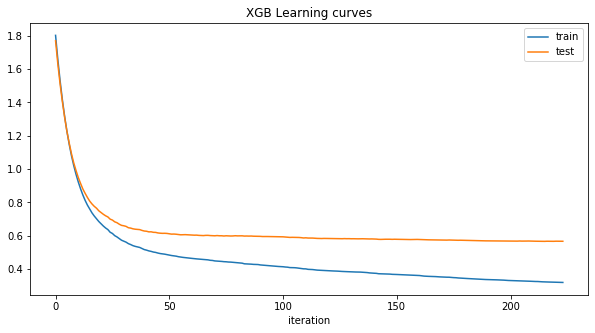

In [88]:
# Построим кривые обучения и валидации с помощью встроенных в XGBoost методов оценки ошибки. 
eval_results = xgb.evals_result()
train_error = eval_results['validation_0']['rmse']
test_error = eval_results['validation_1']['rmse']
df_error = pd.DataFrame([train_error, test_error]).T
df_error.columns = ['train', 'test']
df_error.index.name = 'iteration'
df_error.plot(title = 'XGB Learning curves', figsize=(10,5));


- По кривым обучения видно, что применение раннего останова обучения позволило избежать переобучения модели.


Работа с встроенной функцией Feature_importance: c помощью встроенной в xgboost функции определения важности признаков найдем топ 4 важных признаков и переобучим на них модель.

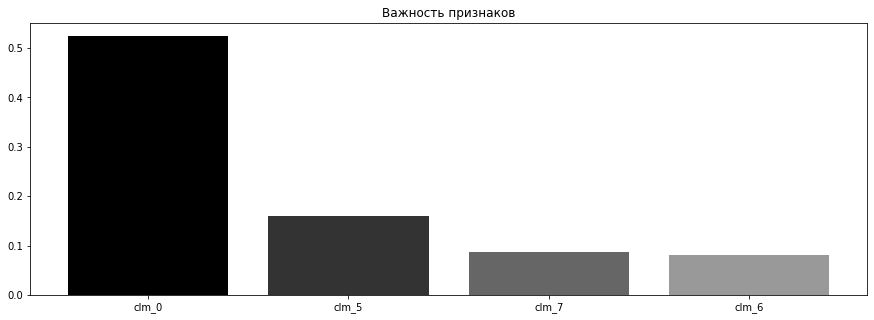

In [89]:
importances = xgb.feature_importances_
indices = np.argsort(importances)[::-1][0: 4]

plt.figure(figsize=(15,5))
plt.title("Важность признаков")
bars = plt.bar(X_train.columns[indices], 
               importances[indices],
       color=([str(i/float(len(indices)+1)) 
               for i in range(len(indices))]),
               align="center")







In [102]:
table = full_df.iloc[:, list(indices)]
table.head()

,clm_0,clm_5,clm_7,clm_6
0,4.1518,4.180593,-117.05,32.58
1,5.7796,3.020979,-117.97,33.92
2,4.3487,2.910112,-121.84,38.65
3,2.4511,2.746479,-115.60,33.20
4,5.0049,1.712401,-122.43,37.79


In [108]:
table = full_df[['clm_0', 'clm_5', 'clm_6', 'clm_7']]
X_train4, X_test4, y_train4, y_test4 = train_test_split(table, 
                                                    full_df['target'], 
                                                    test_size=0.3, 
                                                    random_state=RANDOM_SEED)
xgb = XGBRegressor(n_estimators=1000, random_state=RANDOM_SEED)
xgb.fit(X_train4, y_train4,
        eval_set=[(X_train4, y_train4),
                  (X_test4, y_test4)],
        eval_metric='rmse',
        verbose=True,
        early_stopping_rounds=10
        )

eval_results = xgb.evals_result()
np.round(eval_results['validation_1']['rmse'][175], 3)

np.round(np.sqrt(mean_squared_error(y_test4, xgb.predict(X_test4))))

[19:51:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.80319	validation_1-rmse:1.77049
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.65747	validation_1-rmse:1.63116
[2]	validation_0-rmse:1.5298	validation_1-rmse:1.51029
[3]	validation_0-rmse:1.41583	validation_1-rmse:1.40453
[4]	validation_0-rmse:1.31527	validation_1-rmse:1.30982
[5]	validation_0-rmse:1.22731	validation_1-rmse:1.22576
[6]	validation_0-rmse:1.14922	validation_1-rmse:1.15673
[7]	validation_0-rmse:1.08094	validation_1-rmse:1.09281
[8]	validation_0-rmse:1.02173	validation_1-rmse:1.03849
[9]	validation_0-rmse:0.970138	validation_1-rmse:0.991533
[10]	validation_0-rmse:0.922112	validation_1-rmse:0.950885
[11]	validation_0-rmse:0.882091	validation_1-rmse:0.913413
[12]	validation_0-rmse:0.846066	validation_1-r

[135]	validation_0-rmse:0.413164	validation_1-rmse:0.573075
[136]	validation_0-rmse:0.411487	validation_1-rmse:0.572706
[137]	validation_0-rmse:0.410923	validation_1-rmse:0.572437
[138]	validation_0-rmse:0.410662	validation_1-rmse:0.572368
[139]	validation_0-rmse:0.409922	validation_1-rmse:0.572141
[140]	validation_0-rmse:0.409332	validation_1-rmse:0.57255
[141]	validation_0-rmse:0.408676	validation_1-rmse:0.572435
[142]	validation_0-rmse:0.407267	validation_1-rmse:0.572277
[143]	validation_0-rmse:0.406414	validation_1-rmse:0.571887
[144]	validation_0-rmse:0.405	validation_1-rmse:0.571388
[145]	validation_0-rmse:0.403706	validation_1-rmse:0.571039
[146]	validation_0-rmse:0.403187	validation_1-rmse:0.571053
[147]	validation_0-rmse:0.402574	validation_1-rmse:0.570979
[148]	validation_0-rmse:0.401475	validation_1-rmse:0.570822
[149]	validation_0-rmse:0.400228	validation_1-rmse:0.570185
[150]	validation_0-rmse:0.399474	validation_1-rmse:0.570351
[151]	validation_0-rmse:0.398819	validation_

1.0

### Тюнинг гиперпараметров XGBoost c помощью бибилиотеки hyperopt
Основные параметры:

- learning_rate: шаг обучения;
- max_depth: максимальная глубина дерева.

Параметры семплинга:

- subsample: доля объектов выборки, на которых обучается одно дерево;
- colsample_bytree: доля признаков, на которых обучается одно дерево.

Параметры регуляризации:

- min_child_weight: в задаче регресии - минимальное число листьев в одной ветке дерева;
- gamma: коэффициент, который ограничивает число листьев во всем дереве;
- lambda: L2 - регуляризация весов в листьях;
- alpha: L1 - регуляриазция весов в листьях.

Регуляризация в XGBoost:

\\[L(y,z)+\gamma*J + \frac{\lambda}{2}\Sigma_{j=1}^{J}b_j^2\\]

где J - число листьев в дереве, b - вес в листе.


In [91]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
np.random.seed(RANDOM_SEED)

# XGB parameters for tune
space = {
    'learning_rate': hp.choice('learning_rate',    np.arange(0.01, 0.5, 0.01)),
    'max_depth': hp.choice('max_depth',        np.arange(4, 16, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 10, 1, dtype=int)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'reg_lambda': hp.choice('reg_lambda', np.logspace(-1.0, 2.0, num=100)),
    #'n_estimators': hp.choice('n_estimators',  np.arange(30, 200, 10, dtype=int))
}

# RMSE Cross-validation 
def cv_scores(estimator, X, y, cv=3):
    skf = KFold(n_splits=cv, shuffle=True, random_state=RANDOM_SEED)
    scores=[]
    for train_index, val_index in skf.split(X, y):
        estimator.fit(X.iloc[train_index], y.iloc[train_index])
        y_pred  = estimator.predict(X.iloc[val_index])
        scores.append(np.sqrt(mean_squared_error(y.iloc[val_index], y_pred)))
    return np.mean(scores)

# RMSE test 
def test_scores(estimator, X_train, y_train, X_test, y_test):
    estimator.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              eval_metric = 'rmse',
              early_stopping_rounds = 10,
              verbose = False
             )    
    scores = np.sqrt(mean_squared_error(y_test, estimator.predict(X_test))) 
    return scores, estimator.best_iteration
    
    
def hyperopt_objective(space):
        
    model = XGBRegressor(
        learning_rate = space['learning_rate'],
        max_depth = space['max_depth'],
        min_child_weight = space['min_child_weight'],
        colsample_bytree = space['colsample_bytree'],
        reg_lambda = space['reg_lambda'],
        random_state = RANDOM_SEED,
        n_estimators = 1000 #space['n_estimators']
                        
    )    
    #scores = cv_scores(model, X_train, y_train, cv=3)
    #return np.mean(scores)
    
    scores, best_iteration = test_scores(model, X_train, y_train, X_test, y_test)    
    return {'loss': scores, 'best_iteration': best_iteration, 'status': STATUS_OK}
    
    
trials = Trials()
best_params = fmin(fn = hyperopt_objective,
                   space = space,
                   algo = tpe.suggest,
                   max_evals = 100,
                   trials = trials,
                   verbose = 2,
                   rstate = np.random.seed(RANDOM_SEED),
                   return_argmin=False
                  )

print('Best params:\n', best_params)

[19:12:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:12:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:12:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:12:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:12:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:12:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:12:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:12:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:12:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

In [92]:
res_loss = np.array([res['loss'] for res in trials.results])
best_idx = np.where(res_loss == res_loss.min())[0][0]
best_results = trials.results[best_idx]
best_results

{'loss': 0.5124915765562774, 'best_iteration': 368, 'status': 'ok'}

Оценка влияния параметра **subsample** на дисперсию прогнозов.
Параметр **subsample** - по сути реализация бэггинга внтури XGBoost. Как известно, бэггинг призван снизить дисперсию прогноза, а, следовательно, уменьшить склонность алгоритма к переобучению.
- Оценим дисперсию (можно оценивать стандартное отклонение) прогноза XGBoost при изменении параметра subsample.

In [112]:
# Список subsample, который надо перебрать
subsample_list = np.arange(0.1, 1.1, 0.1)
# Инициализация модели для воспроизводимости ответа
scores = []
for subsmple in subsample_list:
    model = XGBRegressor(n_estimators=20, 
                         max_depth=2,
                         subsample=subsmple,
                         random_state=RANDOM_SEED)
    model.fit(X_train, y_train
        #eval_set=[(X_train, y_train),(X_test, y_test)],
        #eval_metric='rmse'
        #verbose=True,
        #early_stopping_rounds=10
        )
    scores.append(np.std(model.predict(X_test)))

min(zip(subsample_list, scores), key=lambda x: x[1])
    
    
    
    

[20:05:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:05:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:05:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:05:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:05:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:05:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:05:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:05:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:05:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

(0.4, 0.6357199)